# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "None"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
Build your own model
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1, 1e-2, 1e-3]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
OPTIMIZER = ['SGD', 'RMSprop', 'AdaGrad', 'Adam']

In [7]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for opt in OPTIMIZER:
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer = %s, Learning Rate = %3f" % (opt, lr))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        
        optimizer = {
            'SGD': lambda: keras.optimizers.SGD(learning_rate=lr, nesterov=True, momentum=MOMENTUM),
            'RMSprop': lambda: keras.optimizers.RMSprop(learning_rate=lr, rho=0.9),
            'AdaGrad': lambda: keras.optimizers.Adagrad(learning_rate=lr),
            'Adam': lambda: keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
        }.get(opt)
        
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer())
        
        model.fit(x_train, y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(x_test, y_test),
                  shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = "exp-opt-%s-lr-%s" % (str(opt), str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with Optimizer = SGD, Learning Rate = 0.100000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1

50000/50000 [==============================] - 9s 172us/step - loss: 1.4280 - accuracy: 0.4996 - val_loss: 1.6634 - val_accuracy: 0.4404
Epoch 49/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.4255 - accuracy: 0.4982 - val_loss: 1.6731 - val_accuracy: 0.4460
Epoch 50/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4137 - accuracy: 0.5043 - val_loss: 1.5958 - val_accuracy: 0.4430
Experiment with Optimizer = SGD, Learning Rate = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________

50000/50000 [==============================] - 9s 172us/step - loss: 0.4489 - accuracy: 0.8393 - val_loss: 2.1984 - val_accuracy: 0.5247
Epoch 46/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.4238 - accuracy: 0.8470 - val_loss: 2.0887 - val_accuracy: 0.5248
Epoch 47/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.4254 - accuracy: 0.8471 - val_loss: 2.2028 - val_accuracy: 0.5161
Epoch 48/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.4102 - accuracy: 0.8518 - val_loss: 2.1996 - val_accuracy: 0.5129
Epoch 49/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.3867 - accuracy: 0.8608 - val_loss: 2.3203 - val_accuracy: 0.5205
Epoch 50/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.3686 - accuracy: 0.8674 - val_loss: 2.2865 - val_accuracy: 0.5185
Experiment with Optimizer = SGD, Learning Rate = 0.001000
Model: "model_1"
___________________________________________

50000/50000 [==============================] - 8s 169us/step - loss: 0.9732 - accuracy: 0.6591 - val_loss: 1.3907 - val_accuracy: 0.5269
Epoch 43/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.9582 - accuracy: 0.6646 - val_loss: 1.3186 - val_accuracy: 0.5439
Epoch 44/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.9467 - accuracy: 0.6672 - val_loss: 1.3881 - val_accuracy: 0.5293
Epoch 45/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.9342 - accuracy: 0.6743 - val_loss: 1.3887 - val_accuracy: 0.5285
Epoch 46/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.9264 - accuracy: 0.6754 - val_loss: 1.4800 - val_accuracy: 0.5063
Epoch 47/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.9133 - accuracy: 0.6801 - val_loss: 1.3607 - val_accuracy: 0.5344
Epoch 48/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.9039 - accuracy: 0.6824 - val_loss:

50000/50000 [==============================] - 9s 183us/step - loss: 2.3081 - accuracy: 0.0988 - val_loss: 2.3138 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 9s 183us/step - loss: 2.3079 - accuracy: 0.1014 - val_loss: 2.3078 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 9s 182us/step - loss: 2.3079 - accuracy: 0.0981 - val_loss: 2.3202 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 9s 183us/step - loss: 2.3076 - accuracy: 0.1014 - val_loss: 2.3088 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.3078 - accuracy: 0.0991 - val_loss: 2.3126 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.3079 - accuracy: 0.0995 - val_loss: 2.3132 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 9s 183us/step - loss: 2.3075 - accuracy: 0.0999 - val_loss:

50000/50000 [==============================] - 9s 190us/step - loss: 1.8150 - accuracy: 0.3291 - val_loss: 1.7699 - val_accuracy: 0.3473
Epoch 37/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.8093 - accuracy: 0.3300 - val_loss: 1.8098 - val_accuracy: 0.3212
Epoch 38/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.8045 - accuracy: 0.3349 - val_loss: 1.8812 - val_accuracy: 0.3183
Epoch 39/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.8057 - accuracy: 0.3329 - val_loss: 1.8136 - val_accuracy: 0.3305
Epoch 40/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.8028 - accuracy: 0.3373 - val_loss: 1.8269 - val_accuracy: 0.3425
Epoch 41/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.7997 - accuracy: 0.3400 - val_loss: 1.9210 - val_accuracy: 0.2967
Epoch 42/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7986 - accuracy: 0.3363 - val_loss:

50000/50000 [==============================] - 9s 187us/step - loss: 1.0295 - accuracy: 0.6319 - val_loss: 1.8010 - val_accuracy: 0.4506
Epoch 34/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.0169 - accuracy: 0.6348 - val_loss: 1.6170 - val_accuracy: 0.4753
Epoch 35/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9987 - accuracy: 0.6419 - val_loss: 1.6716 - val_accuracy: 0.4736
Epoch 36/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.9910 - accuracy: 0.6451 - val_loss: 1.6505 - val_accuracy: 0.4730
Epoch 37/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.9715 - accuracy: 0.6524 - val_loss: 1.7315 - val_accuracy: 0.4684
Epoch 38/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9556 - accuracy: 0.6554 - val_loss: 1.5884 - val_accuracy: 0.4858
Epoch 39/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.9401 - accuracy: 0.6617 - val_los

50000/50000 [==============================] - 9s 173us/step - loss: 1.4762 - accuracy: 0.4716 - val_loss: 1.5817 - val_accuracy: 0.4443
Epoch 31/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4660 - accuracy: 0.4765 - val_loss: 1.6476 - val_accuracy: 0.4080
Epoch 32/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4638 - accuracy: 0.4764 - val_loss: 1.6270 - val_accuracy: 0.4202
Epoch 33/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4622 - accuracy: 0.4776 - val_loss: 1.5533 - val_accuracy: 0.4463
Epoch 34/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4498 - accuracy: 0.4810 - val_loss: 1.6323 - val_accuracy: 0.4253
Epoch 35/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4410 - accuracy: 0.4819 - val_loss: 1.5857 - val_accuracy: 0.4310
Epoch 36/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4388 - accuracy: 0.4862 - val_loss:

50000/50000 [==============================] - 9s 177us/step - loss: 1.2564 - accuracy: 0.5561 - val_loss: 1.3914 - val_accuracy: 0.5127
Epoch 28/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.2434 - accuracy: 0.5618 - val_loss: 1.4757 - val_accuracy: 0.4896
Epoch 29/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.2331 - accuracy: 0.5633 - val_loss: 1.4155 - val_accuracy: 0.4961
Epoch 30/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.2229 - accuracy: 0.5664 - val_loss: 1.4065 - val_accuracy: 0.5040
Epoch 31/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.2097 - accuracy: 0.5736 - val_loss: 1.4398 - val_accuracy: 0.4853
Epoch 32/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.2054 - accuracy: 0.5756 - val_loss: 1.4081 - val_accuracy: 0.5080
Epoch 33/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.1939 - accuracy: 0.5788 - val_loss:

50000/50000 [==============================] - 9s 175us/step - loss: 1.3834 - accuracy: 0.5176 - val_loss: 1.4387 - val_accuracy: 0.4894
Epoch 25/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.3760 - accuracy: 0.5191 - val_loss: 1.4273 - val_accuracy: 0.4901
Epoch 26/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.3688 - accuracy: 0.5206 - val_loss: 1.4272 - val_accuracy: 0.4884
Epoch 27/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.3622 - accuracy: 0.5250 - val_loss: 1.4229 - val_accuracy: 0.4899
Epoch 28/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.3551 - accuracy: 0.5271 - val_loss: 1.4295 - val_accuracy: 0.4860
Epoch 29/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.3499 - accuracy: 0.5282 - val_loss: 1.4334 - val_accuracy: 0.4886
Epoch 30/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3439 - accuracy: 0.5312 - val_loss:

50000/50000 [==============================] - 11s 210us/step - loss: 2.3070 - accuracy: 0.1026 - val_loss: 2.3047 - val_accuracy: 0.1000
Epoch 22/50
50000/50000 [==============================] - 10s 210us/step - loss: 2.3071 - accuracy: 0.0979 - val_loss: 2.3078 - val_accuracy: 0.1000
Epoch 23/50
50000/50000 [==============================] - 11s 210us/step - loss: 2.3071 - accuracy: 0.1009 - val_loss: 2.3070 - val_accuracy: 0.1000
Epoch 24/50
50000/50000 [==============================] - 11s 210us/step - loss: 2.3074 - accuracy: 0.0979 - val_loss: 2.3060 - val_accuracy: 0.1000
Epoch 25/50
50000/50000 [==============================] - 11s 213us/step - loss: 2.3075 - accuracy: 0.0986 - val_loss: 2.3066 - val_accuracy: 0.1000
Epoch 26/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.3068 - accuracy: 0.1015 - val_loss: 2.3066 - val_accuracy: 0.1000
Epoch 27/50
50000/50000 [==============================] - 11s 212us/step - loss: 2.3066 - accuracy: 0.1011 - va

50000/50000 [==============================] - 10s 207us/step - loss: 1.5460 - accuracy: 0.4432 - val_loss: 1.5800 - val_accuracy: 0.4344
Epoch 19/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.5458 - accuracy: 0.4438 - val_loss: 1.5814 - val_accuracy: 0.4331
Epoch 20/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.5253 - accuracy: 0.4518 - val_loss: 1.5900 - val_accuracy: 0.4274
Epoch 21/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.5286 - accuracy: 0.4499 - val_loss: 1.6075 - val_accuracy: 0.4301
Epoch 22/50
50000/50000 [==============================] - 11s 214us/step - loss: 1.5370 - accuracy: 0.4476 - val_loss: 1.6439 - val_accuracy: 0.4204
Epoch 23/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.5318 - accuracy: 0.4488 - val_loss: 1.6114 - val_accuracy: 0.4326
Epoch 24/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.5311 - accuracy: 0.4505 - va

50000/50000 [==============================] - 11s 214us/step - loss: 1.2478 - accuracy: 0.5542 - val_loss: 1.4521 - val_accuracy: 0.4901
Epoch 16/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.2168 - accuracy: 0.5644 - val_loss: 1.3849 - val_accuracy: 0.5092
Epoch 17/50
50000/50000 [==============================] - 11s 214us/step - loss: 1.2099 - accuracy: 0.5703 - val_loss: 1.3449 - val_accuracy: 0.5284
Epoch 18/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.1819 - accuracy: 0.5785 - val_loss: 1.3782 - val_accuracy: 0.5129
Epoch 19/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.1531 - accuracy: 0.5906 - val_loss: 1.3643 - val_accuracy: 0.5266
Epoch 20/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.1315 - accuracy: 0.5978 - val_loss: 1.3901 - val_accuracy: 0.5150
Epoch 21/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.1150 - accuracy: 0.6019 - va

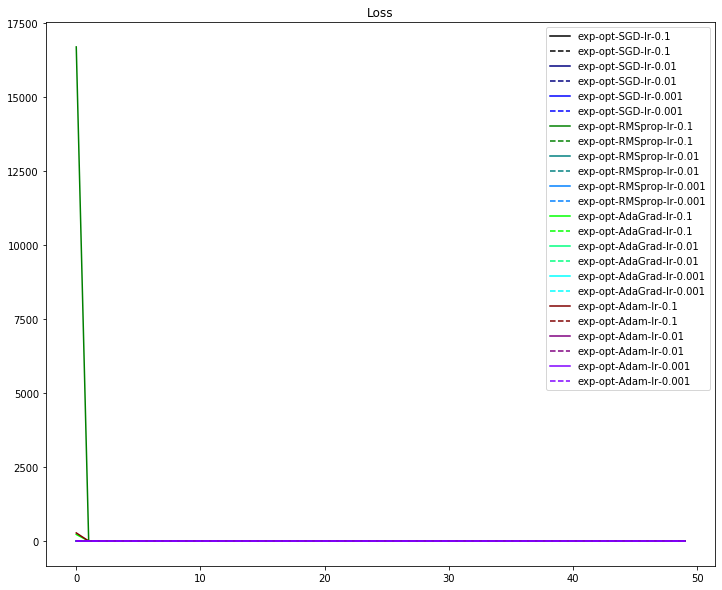

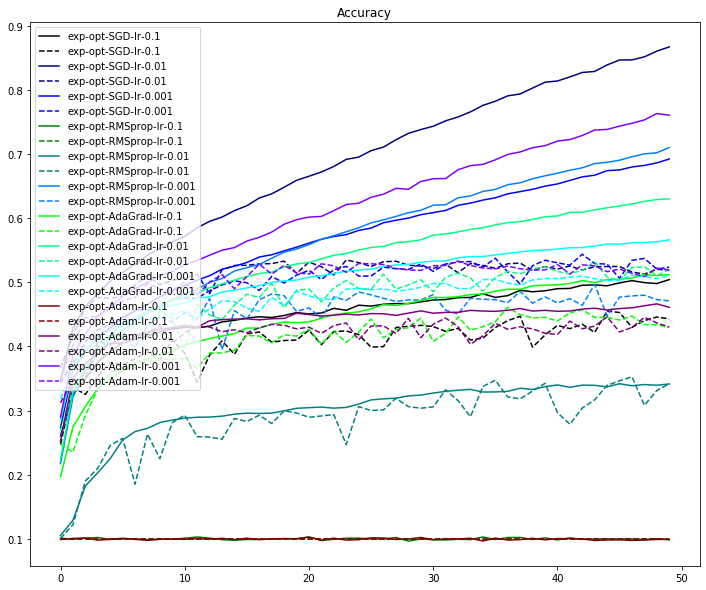

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['#000000', '#000080', '#0000ff', '#008000',
             '#008080', '#0080ff', '#00ff00', '#00ff80',
             '#00ffff', '#800000', '#800080', '#8000ff']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc = 'upper right')
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc = 'upper left')
plt.show()